In [143]:
import sys
print(sys.version)

3.13.9 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 19:09:58) [MSC v.1929 64 bit (AMD64)]


# Libraries

In [144]:
import pandas as pd
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

# Dataframe Preperation<br> 

Overview
- Rail Accident df stored at "df_accident"
- Population df stored at "df_population"

In [145]:
rail_accident_path = "./data/raw/Rail_Equipment_Accident_Incident_Data_(Form_54)_20260114.csv.zip"
population_path = "./data/raw/Ruralurbancontinuumcodes2023.csv"

df_accident_all = pd.read_csv(
    rail_accident_path,
    low_memory = False
)
df_population = pd.read_csv(
    population_path,
    encoding="latin1"
)

In [146]:
print(df_accident_all.shape)
print(df_population.shape)

(223529, 155)
(9703, 5)


## Dataframe: Rail Accidents

Overview
- Year: int
- State Code: int
- County Code: float

In [147]:
print(df_accident_all.head(0))

Empty DataFrame
Columns: [Reporting Railroad Code, Reporting Railroad Name, Year, Accident Number, PDF Link, Accident Year, Accident Month, Other Railroad Code, Other Railroad Name, Other Accident Number, Other Accident Year, Other Accident Month, Maintenance Railroad Code, Maintenance Railroad Name, Maintenance Accident Number, Maintenance Accident Year, Maintenance Accident Month, Grade Crossing ID, Day, Date, Time, Accident Type Code, Accident Type, Hazmat Cars, Hazmat Cars Damaged, Hazmat Released Cars, Persons Evacuated, Subdivision, Division Code, Division, Station, Milepost, State Code, State Abbreviation, State Name, County Code, County Name, District, Temperature, Visibility Code, Visibility, Weather Condition Code, Weather Condition, Track Type Code, Track Type, Track Name, Track Class, Track Density, Train Direction Code, Train Direction, Equipment Type Code, Equipment Type, Equipment Attended, Train Number, Train Speed, Recorded Estimated Speed, Maximum Speed, Gross Tonnage

In [148]:
print(df_accident_all["Year"].dtype)
print(df_accident_all["State Code"].dtype)
print(df_accident_all["County Code"].dtype)

int64
int64
float64


### Grabbing items pass 2011

Accident Form updated at 2011

In [149]:
df_accident = df_accident_all[df_accident_all["Year"] > 2011]

In [150]:
print(df_accident.head())

     Reporting Railroad Code                          Reporting Railroad Name  \
50                      BNSF                             BNSF Railway Company   
54                       CSX                               CSX Transportation   
56                       CSX                               CSX Transportation   
58                       CSX                               CSX Transportation   
1159                    SFRV  South Florida Regional Transportation Authority   

      Year Accident Number                                           PDF Link  \
50    2013       NW0813104  https://safetydata.fra.dot.gov/Officeofsafety/...   
54    2014       000131012  https://safetydata.fra.dot.gov/Officeofsafety/...   
56    2020       000191201  https://safetydata.fra.dot.gov/Officeofsafety/...   
58    2013       000121335  https://safetydata.fra.dot.gov/Officeofsafety/...   
1159  2024        03172024  https://safetydata.fra.dot.gov/Officeofsafety/...   

      Accident Year  Accid

In [151]:
df_accident[["Year", "State Code", "County Code"]].head()

,Year,State Code,County Code
50,2013,53,53.0
54,2014,21,15.0
56,2020,47,37.0
58,2013,45,47.0
1159,2024,12,99.0


## Dataframe: Population

Overview
- FIPS: int
- Value(population): object
- Value has three occurences
    - 1: Numeric value of population
    - 2: Rural-urban code
    - 3: Description of that code

In [152]:
print(df_population.head(0))

Empty DataFrame
Columns: [FIPS, State, County_Name, Attribute, Value]
Index: []


In [153]:
print(df_population["FIPS"].dtype)
print(df_population["Value"].dtype)

int64
object


In [154]:
print(df_population[["FIPS", "Value"]].head())

   FIPS                                              Value
0  1001                                              58805
1  1001                                                  2
2  1001  Metro - Counties in metro areas of 250,000 to ...
3  1003                                             231767
4  1003                                                  3


In [155]:
print(df_population["Value"].values)

['58805' '2'
 'Metro - Counties in metro areas of 250,000 to 1 million population' ...
 '42261' '5'
 'Nonmetro - Urban population of 20,000 or more, not adjacent to a metro area']


In [156]:
print(df_population["FIPS"].values)

[ 1001  1001  1001 ... 78030 78030 78030]


# Data Cleaning

- FIPS (used to determine location) is 5 digits = State Code + County Code
- Find potential Null values

## Dataframe: Rail Accidents

Overview
- One Null "County Code"
- None Null "State Code"
- Fix FIPS code (5 digits)
    - County code is float

In [157]:
df_accident["State Code"].isna().sum()

np.int64(0)

In [158]:
df_accident["County Code"].isna().sum()

np.int64(1)

In [159]:
df_accident = df_accident.dropna(subset=["County Code"])

In [160]:
df_accident["County Code"].isna().sum()

np.int64(0)

In [161]:
df_accident["State Code"] = df_accident["State Code"].astype(str).str.zfill(2)
df_accident["County Code"] = df_accident["County Code"].astype(int).astype(str).str.zfill(3)

df_accident["FIPS"] = df_accident["State Code"] + df_accident["County Code"]

In [162]:
print(df_accident[["State Code", "County Code", "FIPS"]])

       State Code County Code   FIPS
50             53         053  53053
54             21         015  21015
56             47         037  47037
58             45         047  45047
1159           12         099  12099
...           ...         ...    ...
213011         12         127  12127
215507         01         073  01073
216098         01         073  01073
217191         01         097  01097
217965         01         001  01001

[34813 rows x 3 columns]


## Dataframe: Population

Overview
- None Null "FIPS"
- None Null "Value"
- Fix FIPS code (5 digits)

In [163]:
print(df_population["FIPS"].isna().sum())
print(df_population["Value"].isna().sum())

0
0


In [164]:
df_population["FIPS"] = df_population["FIPS"].astype(str).str.zfill(5)

## Dataframe Merging

In [165]:
df_population["code_bool"] = df_population.groupby("FIPS").cumcount() == 1
code_value = df_population[df_population["code_bool"]].copy()
code_value = code_value[["FIPS", "Value"]]
code_value.rename(columns={"Value":"Code"}, inplace=True)

df_population["pop_bool"] = df_population.groupby("FIPS").cumcount() == 0
population_value = df_population[df_population["pop_bool"]].copy()
population_value = population_value[["FIPS", "Value"]]

In [166]:
df_pop_code = code_value.merge(
    population_value,
    on="FIPS",
    how="left"
)

In [167]:
print(df_pop_code[["FIPS", "Value", "Code"]].head())

    FIPS   Value Code
0  01001   58805    2
1  01003  231767    3
2  01005   25223    6
3  01007   22293    1
4  01009   59134    1


In [168]:
df = df_accident.merge(
    df_pop_code,
    on="FIPS",
    how="left"
)
print(df[["State Code", "County Code", "FIPS", "Value", "Code"]].head())

  State Code County Code   FIPS    Value Code
0         53         053  53053   921130    1
1         21         015  21015   135968    1
2         47         037  47037   715884    1
3         45         047  45047    69351    4
4         12         099  12099  1492191    1


## Data Cleaning

In [169]:
print(df["Code"].isnull().sum())

251


In [172]:
df = df.dropna(subset=["Code"])
print(df["Code"].isnull().sum())

0


In [173]:
print(df["Value"].isnull().sum())

0


In [174]:
df = df.dropna(subset=["Value"])
print(df["Value"].isnull().sum())

0


In [175]:
print(df["Value"].dtype)

object


In [176]:
df["Value"] = df["Value"].astype(int)

## Reports

In [178]:
accident_list = df["FIPS"].value_counts()

df_accident_count = accident_list.rename("Accidents").reset_index()
df_accident_count.rename(columns={"index":"FIPS"}, inplace=True)

population_value = df.drop_duplicates(subset="FIPS").set_index("FIPS")["Value"]
df_accident_count["Population"] = df_accident_count["FIPS"].map(population_value)

code_value = df.drop_duplicates(subset="FIPS").set_index("FIPS")["Code"]
df_accident_count["Code"] = df_accident_count["FIPS"].map(code_value)


In [179]:
print(df_accident_count.head(20))

     FIPS  Accidents  Population Code
0   17031       1295     5275541    1
1   48201        892     4731145    1
2   31111        502       34676    5
3   06071        475     2181654    1
4   01073        448      674721    1
5   48439        438     2110640    1
6   06037        388    10014009    1
7   20209        369      169245    1
8   17163        300      257400    1
9   18089        295      498700    1
10  47157        272      929744    1
11  34017        265      724854    1
12  13121        262     1066710    1
13  05119        257      399125    2
14  48029        242     2009324    1
15  36001        228      314848    2
16  29095        220      717204    1
17  18039        213      207047    3
18  22077        205       20758    2
19  05069        201       67260    4


### Accidents vs Population

In [180]:
x = df_accident_count["Accidents"]
y = df_accident_count["Population"]

In [181]:
correlation = x.corr(y)
print("Correlation:", correlation)

Correlation: 0.5886182177549892


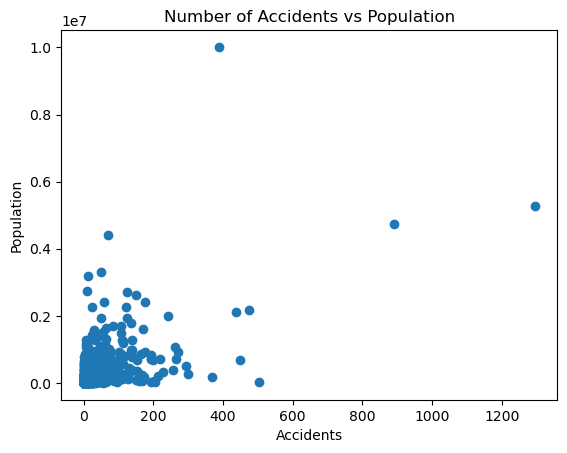

In [182]:
plt.scatter(x,y)
plt.title("Number of Accidents vs Population")
plt.xlabel("Accidents")
plt.ylabel("Population")
plt.show()

### Accidents vs Continuum Codes

In [183]:
x = df_accident_count["Accidents"]
y = df_accident_count["Code"]

In [184]:
correlation = x.corr(y)
print("Correlation:", correlation)

Correlation: -0.23349245738710186


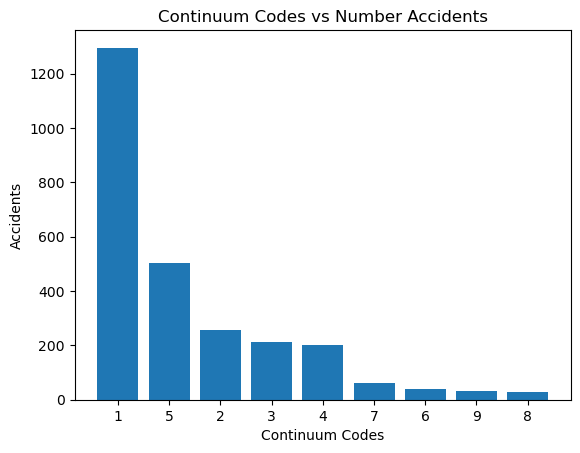

In [188]:
plt.bar(y,x)
plt.title("Continuum Codes vs Number Accidents")
plt.xlabel("Continuum Codes")
plt.ylabel("Accidents")
plt.show()